In [1]:
import pandas as pd
import numpy as np
import sys
import os
import torch
import matplotlib.pyplot as plt
sys.path.append(".//Beamforming-main//")
from dataloader_gpu import create_data_loaders
from models import *
from loss import *

In [2]:
os.listdir(os.path.join(repo_dir, 'Beamforming-main\\autoencoder_checkpoints\\position'))

NameError: name 'repo_dir' is not defined

In [2]:
repo_dir = 'C:\\Users\\admin\\Desktop\\iot'

input_type = ['azimuthal', 'position', 'azimuthal_position']
input_size=[2,3,5]
input_col = [[0,1,5,6], [2,3,4,7,8,9], list(range(10))]

models = ['lstmattention', 'lstmmodel', 'model1', 'model2','model3']
i,m = 0,4

# checkpoint_dir = os.path.join(repo_dir, 'Beamforming-main\\autoencoder_checkpoints\\position\\model1')
checkpoint_dir = os.path.join(repo_dir, f'Beamforming-main\\autoencoder_checkpoints\\{input_type[i]}\\{models[m]}')
checkpoint_files = os.listdir(path=checkpoint_dir)
checkpoint_dir

'C:\\Users\\admin\\Desktop\\iot\\Beamforming-main\\autoencoder_checkpoints\\azimuthal\\model3'

In [3]:
%%time
training_report = []
for file in checkpoint_files:
    data = torch.load(os.path.join(checkpoint_dir,file))
    training_report.append([data['epoch'], data['train_loss'], data['val_loss']])

report_df = pd.DataFrame(training_report, columns=['epoch','training_loss','val_loss'])
report_df.sort_values(by='epoch', axis=0, ignore_index=True, inplace=True)
report_df.head()

CPU times: total: 2.27 s
Wall time: 3.95 s


,epoch,training_loss,val_loss
0,1,0.080200,0.063543
1,2,0.048505,0.038073
2,3,0.032138,0.027966
3,4,0.025620,0.023824
4,5,0.022699,0.021694


In [4]:
report_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   epoch          200 non-null    int64  
 1   training_loss  200 non-null    float64
 2   val_loss       200 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 4.8 KB


training and validation loss

[]

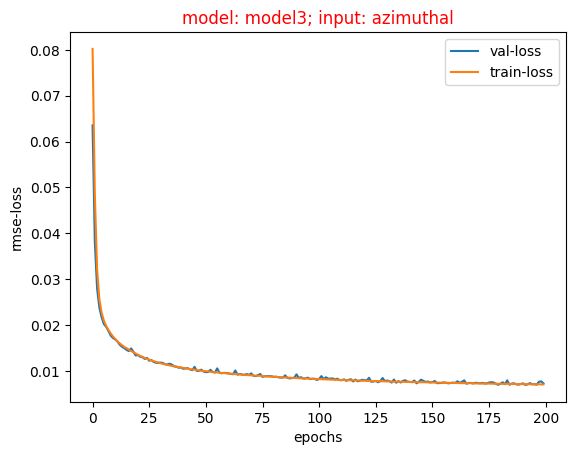

In [5]:
plt.plot(report_df.val_loss.values,label="val-loss")
plt.plot(report_df.training_loss.values,label="train-loss")
plt.xlabel("epochs")
plt.ylabel("rmse-loss")
plt.legend()
plt.title(f'model: {models[m]}; input: {input_type[i]}',color='r')
plt.plot()

loading test data

In [6]:
%%time
input_data = os.path.join(repo_dir,'Data\\input_signal_data.csv')
output_data = os.path.join(repo_dir,'Data\\output_weight_parameters_data.csv')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_loader,val_loader,test_loader = create_data_loaders(input_data, 
                                                          output_data, 
                                                          batch_size=1024, 
                                                          input_col=input_col[i], 
                                                          input_size=input_size[i],
                                                          device=device)

Device for Dataloder: cuda
CPU times: total: 50.7 s
Wall time: 45.3 s


In [9]:
best_epoch = report_df[report_df.val_loss==report_df.val_loss.min()].epoch.to_list()[0]
# checkpoint_path = f'C:\\Users\\admin\\Desktop\\iot\\Beamforming-main\\autoencoder_checkpoints\\azimuthal_position\\model2\\model_checkpoint_epoch_{best_epoch}.pt'
checkpoint_path = os.path.join(checkpoint_dir,f'model_checkpoint_epoch_{best_epoch}.pt')
checkpoint=torch.load(checkpoint_path)

hidden_size=576
num_layers=4
output_size=128
num_heads=4

#model = LSTMModelWithMultiheadAttention(input_size[i],hidden_size,num_layers,output_size,num_heads).to(device)
#model = LSTMModel(input_size[i],hidden_size,num_layers,output_size).to(device)
# model = Model1().to(device)
# model = Model2().to(device)
model = Model3().to(device)
model.load_state_dict(checkpoint['model_state_dict'])
criterion = RMSELoss()

In [10]:
%%time
def calculate_loss(model, loader, name, printif=False):
    print(name)
    batch = 1
    losses = []
    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        losses.append(float(loss))
        if printif:
            print(f'batch: {batch}: rmse-loss: {loss}')
        batch+=1
        return losses

print('Calculating loss for')
test_losses = calculate_loss(model, test_loader, name='\ttest data')
train_losses = calculate_loss(model, train_loader, name='\ttraining data')
val_losses = calculate_loss(model, val_loader, name='\tvalidation data')

Calculating loss for
	test data
	training data
	validation data
CPU times: total: 3 s
Wall time: 258 ms


In [11]:
print('loss of')
print('|- test:',np.mean(test_losses))
print('|- validation:',np.mean(val_losses))
print('|- train:',np.mean(train_losses))

loss of
|- test: 0.006930566392838955
|- validation: 0.006974918767809868
|- train: 0.0069183772429823875
